## Modeling for predicting hospitalization at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import numpy as np
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
path = '/home/logasan/mimic4ed-benchmark/Benchmark_scripts/processed/'
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95

In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.9157284785879691 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

In [11]:
# Hyperparameter tuning for Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
para_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : [100,10,1,0.1,0.01],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
]

clf = GridSearchCV(logreg,param_grid=para_grid,cv=3,verbose=1,n_jobs=-1)
best_clf = clf.fit(X_train,y_train)
best_clf.best_estimator_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/logasan/mimic4ed-benchmark/MyDemoEnv/lib

LogisticRegression(C=100, max_iter=10000, solver='liblinear')

Logistic Regression:
Training time: 13.226903438568115 seconds
AUC: 0.8117969213104496
AUPRC: 0.7811906785961503
Sensitivity: 0.759162792870658
Specificity: 0.7112521565035889
Score thresold: 0.4425567313890093
2.5 97.5


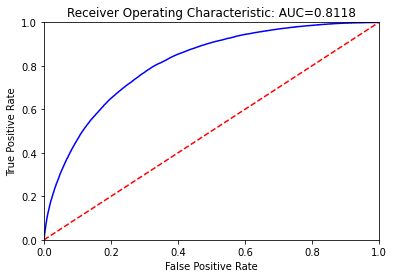

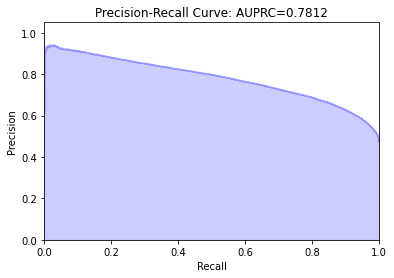

In [12]:
print("Logistic Regression:")
logreg=LogisticRegression(C=100, max_iter=10000, solver='liblinear')
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 444.39930629730225 seconds
AUC: 0.8225262675040461
AUPRC: 0.7979595601878058
Sensitivity: 0.7609614800626037
Specificity: 0.7238184490213201
Score thresold: 0.4421379144471073
2.5 97.5


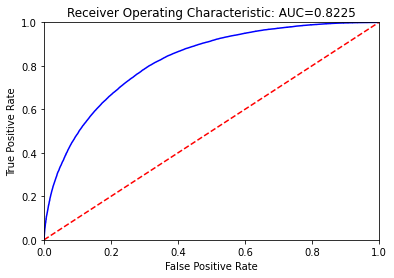

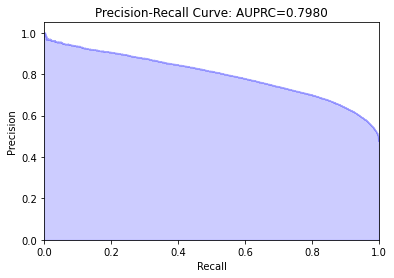

In [13]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


In [14]:
# Hyperparameter tuning for RandomForest
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_jobs=-1)
para_grid = [
    {'max_features' : ['auto','sqrt','log2'],
    'n_estimators' : [100,200,400,600,800,1000,1200,1400,1600,1800,2000],
    'max_depth' : [10,20,30,40,50,60,70,80,90,100]
    }
]

clf = RandomizedSearchCV(estimator=rf,param_distributions=para_grid,cv=3,verbose=2)
best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..max_depth=60, max_features=log2, n_estimators=400; total time=  17.2s
[CV] END ..max_depth=60, max_features=log2, n_estimators=400; total time=  16.3s
[CV] END ..max_depth=60, max_features=log2, n_estimators=400; total time=  16.2s
[CV] END ..max_depth=90, max_features=sqrt, n_estimators=800; total time=  34.8s
[CV] END ..max_depth=90, max_features=sqrt, n_estimators=800; total time=  35.0s
[CV] END ..max_depth=90, max_features=sqrt, n_estimators=800; total time=  34.9s
[CV] END ..max_depth=50, max_features=log2, n_estimators=200; total time=   8.7s
[CV] END ..max_depth=50, max_features=log2, n_estimators=200; total time=   8.8s
[CV] END ..max_depth=50, max_features=log2, n_estimators=200; total time=   8.7s
[CV] END .max_depth=50, max_features=log2, n_estimators=2000; total time= 1.3min
[CV] END .max_depth=50, max_features=log2, n_estimators=2000; total time= 1.3min
[CV] END .max_depth=50, max_features=log2, n_est

{'n_estimators': 1800, 'max_features': 'log2', 'max_depth': 30}

RandomForest:
Training time: 798.663010597229 seconds
AUC: 0.8261881490097662
AUPRC: 0.8002286575701077
Sensitivity: 0.7552617440257889
Specificity: 0.7413260633426337
Score thresold: 0.49174886942668805
2.5 97.5


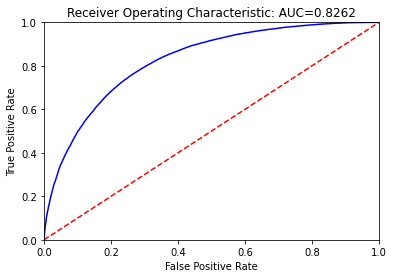

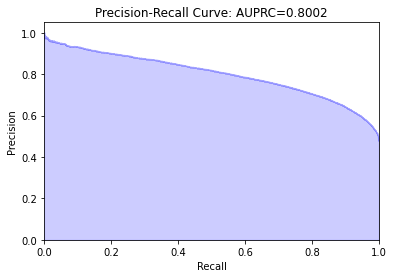

[0.11891122 0.01142016 0.0094046  0.01418348 0.02597036 0.00937288
 0.02131131 0.03138962 0.0010718  0.00252331 0.00695473 0.05675988
 0.06157859 0.03249806 0.05371381 0.06097572 0.05906172 0.04630949
 0.14607926 0.00672793 0.01013258 0.00535562 0.00055253 0.00418536
 0.00293009 0.00354342 0.00483787 0.00329283 0.00408359 0.00442166
 0.00722891 0.00419224 0.00385271 0.00188863 0.00739085 0.00271275
 0.00202594 0.0052527  0.00757681 0.00464567 0.00159258 0.0081592
 0.00613508 0.00195702 0.00273848 0.0014154  0.00959718 0.0038192
 0.00338657 0.00768264 0.01283707 0.00550814 0.0051604  0.00127333
 0.0059477  0.0057399  0.00474938 0.01605179 0.00153232 0.00438326
 0.00610226 0.00530113 0.00358149 0.00902777]


In [15]:
print("RandomForest:")
rf= RandomForestClassifier(n_estimators= 1800,max_features='log2',max_depth=30)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
# Hyperparameter tuning for Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
para_grid = [
    {'learning_rate' : [0.01,0.1,1,10,100],
    'n_estimators' : [5,50,250,500],
    'max_depth' : [1,3,5,7,9],
    }
]

clf = RandomizedSearchCV(estimator=gb,param_distributions=para_grid,cv=3,verbose=2)
best_clf = clf.fit(X_train,y_train)
best_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...learning_rate=100, max_depth=9, n_estimators=500; total time=10.9min
[CV] END ...learning_rate=100, max_depth=9, n_estimators=500; total time=11.1min
[CV] END ...learning_rate=100, max_depth=9, n_estimators=500; total time=11.1min
[CV] END ....learning_rate=100, max_depth=3, n_estimators=50; total time=  20.7s
[CV] END ....learning_rate=100, max_depth=3, n_estimators=50; total time=  20.2s
[CV] END ....learning_rate=100, max_depth=3, n_estimators=50; total time=  20.2s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  49.0s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  49.2s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  49.3s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=  34.0s
[CV] END ..learning_rate=0.01, max_depth=1, n_estimators=250; total time=  33.8s
[CV] END ..learning_rate=0.01, max_depth=1, n_es

{'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1}

GradientBoosting:
Training time: 80.25000357627869 seconds
AUC: 0.8251125349376717
AUPRC: 0.8011588965165353
Sensitivity: 0.7532061015207082
Specificity: 0.7397925496794531
Score thresold: 0.4896848922972623
2.5 97.5


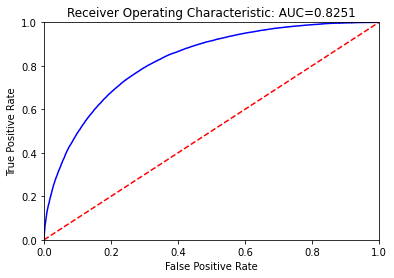

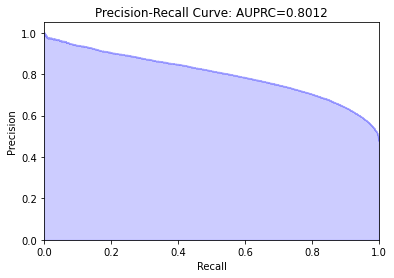

In [17]:
print("GradientBoosting:")
gb = GradientBoostingClassifier(n_estimators=50,max_depth=7,learning_rate=0.1)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [18]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [19]:
def get_score_performance(s):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7122183722345881
AUPRC: 0.6340355405931188
Sensitivity: 0.5952720222383143
Specificity: 0.774914272326468
Score thresold: -2.6248987751080204
2.5 97.5


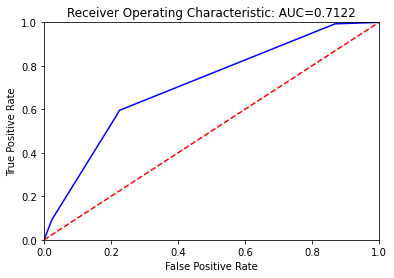

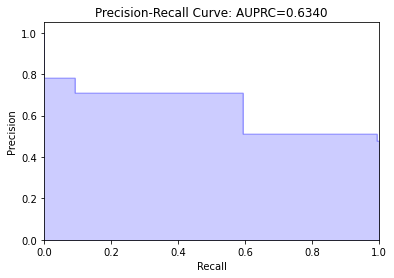

In [20]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi")

score_NEWS
AUC: 0.5743951007088118
AUPRC: 0.5551390217473994
Sensitivity: 0.5493237403349763
Specificity: 0.5455900832783114
Score thresold: 1
2.5 97.5


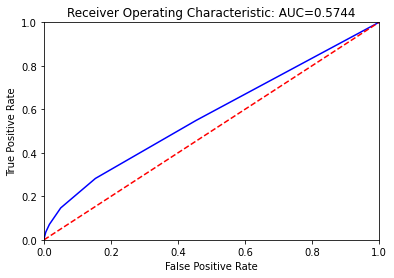

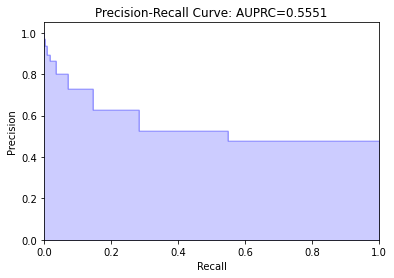

In [21]:
get_score_performance("score_NEWS")

score_NEWS2
AUC: 0.5567351357051066
AUPRC: 0.5382689853343715
Sensitivity: 0.502791469083604
Specificity: 0.5680816170049626
Score thresold: 1
2.5 97.5


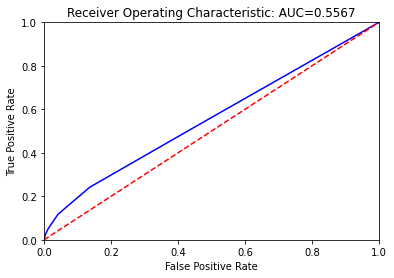

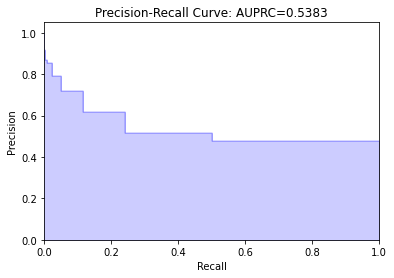

In [22]:
get_score_performance("score_NEWS2")

score_REMS
AUC: 0.6715001298214877
AUPRC: 0.6122906627833825
Sensitivity: 0.7118596556798804
Specificity: 0.5650997848821111
Score thresold: 3
2.5 97.5


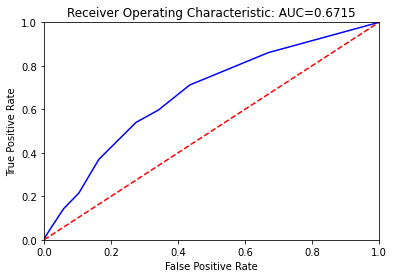

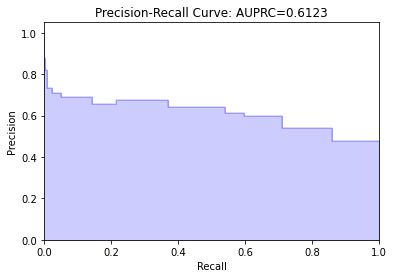

In [23]:
get_score_performance("score_REMS")

score_MEWS
AUC: 0.5573054456894385
AUPRC: 0.5246811307761181
Sensitivity: 0.290242705973043
Specificity: 0.8138271815296798
Score thresold: 2
2.5 97.5


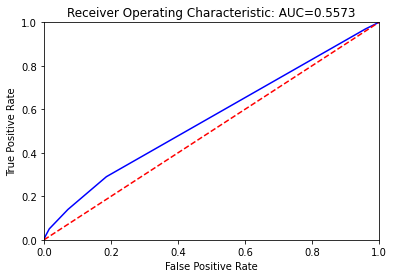

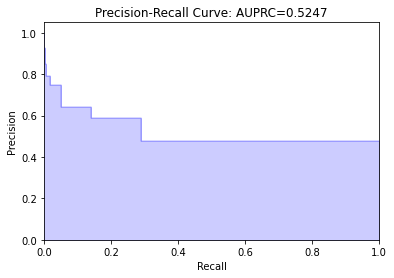

In [24]:
get_score_performance("score_MEWS")

score_CART
AUC: 0.6740959981091517
AUPRC: 0.6199567036795708
Sensitivity: 0.6985914176925413
Specificity: 0.589827692700901
Score thresold: 4
2.5 97.5


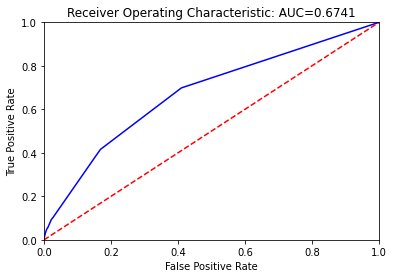

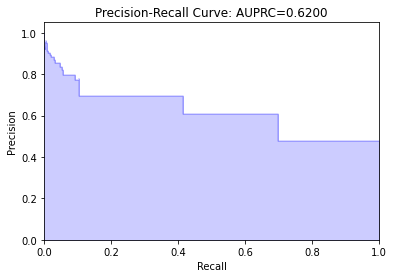

In [25]:
get_score_performance("score_CART")

### 4. Performance output

In [26]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.811797,0.781191,0.759163,0.711252,0.442557,0.808751,0.814501,0.001512,0.776979,0.785653,0.002247,0.735609,0.763006,0.008507,0.707699,0.733061,0.007687,13.226903
1,MLP,0.822526,0.797960,0.760961,0.723818,0.442138,0.819669,0.824859,0.001411,0.794312,0.801710,0.001942,0.740642,0.765437,0.006683,0.720058,0.742185,0.005934,444.399306
2,RF,0.826188,0.800229,0.755262,0.741326,0.491749,0.823679,0.828706,0.001339,0.796706,0.804256,0.001918,0.748243,0.766759,0.005318,0.730941,0.749353,0.005367,798.663011
3,GB,0.825113,0.801159,0.753206,0.739793,0.489685,0.822505,0.827537,0.001347,0.797568,0.805293,0.001915,0.740727,0.765406,0.006423,0.729718,0.751850,0.006244,80.250004
4,esi,0.712218,0.634036,0.595272,0.774914,-2.624899,0.709384,0.714958,0.001562,0.629978,0.638367,0.002115,0.590210,0.599355,0.002299,0.771788,0.778294,0.001833,0.000000
5,score_NEWS,0.574395,0.555139,0.549324,0.545590,1.000000,0.570561,0.577984,0.001855,0.550620,0.559481,0.002300,0.545109,0.553523,0.002417,0.540721,0.550225,0.002403,0.000000
6,score_NEWS2,0.556735,0.538269,0.502791,0.568082,1.000000,0.553045,0.560331,0.001827,0.533922,0.542783,0.002219,0.498547,0.507696,0.002367,0.562623,0.572600,0.002391,0.000000
7,score_REMS,0.671500,0.612291,0.711860,0.565100,3.000000,0.668328,0.675802,0.001914,0.607214,0.617042,0.002486,0.707848,0.716610,0.002383,0.560821,0.570238,0.002411,0.000000
8,score_MEWS,0.557305,0.524681,0.290243,0.813827,2.000000,0.554379,0.560270,0.001511,0.521189,0.528652,0.002056,0.285681,0.294123,0.002219,0.810444,0.817235,0.001731,0.000000
9,score_CART,0.674096,0.619957,0.698591,0.589828,4.000000,0.671343,0.678082,0.001817,0.615139,0.624356,0.002284,0.694166,0.703942,0.002375,0.585626,0.594231,0.002242,0.000000


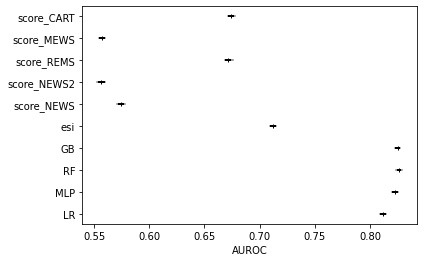

In [27]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )

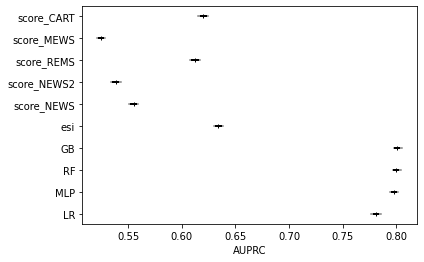

In [28]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC" )

In [29]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
18,triage_acuity,0.146079
0,age,0.118911
12,triage_heartrate,0.061579
15,triage_sbp,0.060976
16,triage_dbp,0.059062
11,triage_temperature,0.056760
14,triage_o2sat,0.053714
17,triage_pain,0.046309
13,triage_resprate,0.032498
7,n_hosp_365d,0.031390
